#### Kaggleの Home Credit Default Risk コンペティションの学習および推定を行います。

## 【問題1】コンペティション内容の確認  

>コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。
>


#### 何を学習し、何を予測するのか  
application_train.csvに含まれる電話会社や取引情報などのさまざまな特徴量を学習させ、TARGET変数（クライアントに返済能力があるか）の確率を予測する。  

#### どのようなファイルを作りKaggleに提出するか  
テストセット内のSK_ID_CURRごとに、TARGET変数の確率を予測し、ヘッダーをつけた形式で提出する。（samplesubmission.csvと同様の形式で提出する。）  

| SK_ID_CURR   | TARGET   | 
| --- | --- |  
| 100001   | 0.1   | 
| 100005   | 0.9   | 
| 100013   | 0.2   | 

#### 提出されたものはどういった指標値で評価されるのか
予測された確率と観測されたターゲットの間のROC曲線の下の領域で評価される。  
ROC曲線は、さまざまなしきい値設定での偽陽性率（FPR）に対して真陽性率（TPR）をプロットすることによって作成される。  
計算はsckit-learnのpredict_probaメソッドを使用する。確率は２列で出力されるが（[0, 1]）、ローンが返済されない確率が知りたいので２列目（[:, 1]）を提出。

&nbsp;Make predictions  
&nbsp;Make sure to select the second column only  
&nbsp;log_reg_pred = log_reg.predict_proba(test)[:, 1]  

&nbsp;Submission dataframe  
&nbsp;submit = app_test[['SK_ID_CURR']]   
&nbsp;submit['TARGET'] = log_reg_pred  
&nbsp;submit.head()  

（Reference）https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction  

## ベースラインモデルの作成  
>まずは単純な方法による ベースラインモデル　を作成します。精度の基準となるモデルです。
>
>精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。

## 【問題2】学習と検証  

>データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。
>検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# データセットcsvをpandasに読み込む

# 学習データの読み込み
csv_path = "./Kaggle_data/HomeCredit/application_train.csv" 
df = pd.read_csv(csv_path)

# テストデータの読み込み
csv_path = "./Kaggle_data/HomeCredit/application_test.csv" 
df_test = pd.read_csv(csv_path)

display(df_test)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


#### データ分析

各ラベルの特性がよく出ている以下の特徴量を用いて学習を実施する。  
'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'

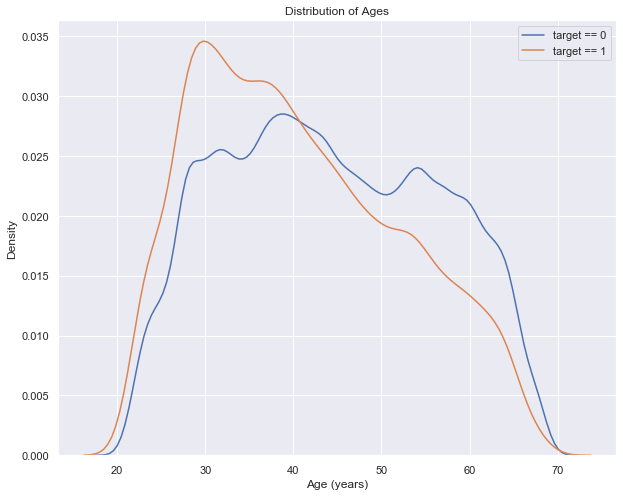

In [3]:
# (Refarance)https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
    
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(0-df.loc[df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(0-df.loc[df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

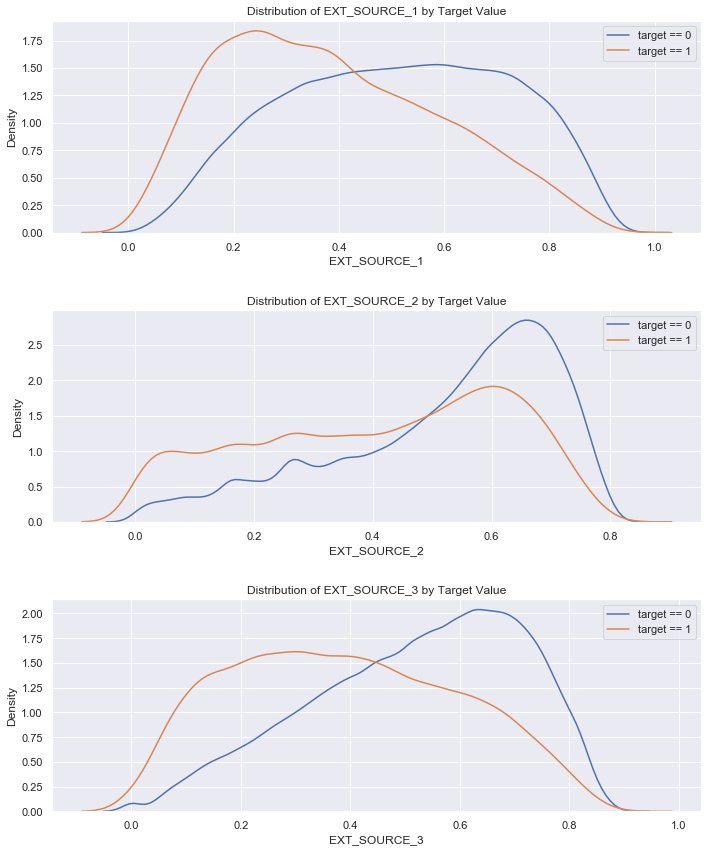

In [4]:
# (Refarance)https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [5]:
#　データ欠損の確認
df[['DAYS_BIRTH','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].isnull().sum()

DAYS_BIRTH           0
EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

In [6]:
# 必要なデータを抜き出す
df_X = df[['DAYS_BIRTH','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
df_y = df[['TARGET']]

df2 = pd.concat([df_X,df_y], axis=1)

# テストデータを抜き出す
df2_t = df_test[['SK_ID_CURR','DAYS_BIRTH','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

# テストデータは欠損値に対して行削除で対応できないため、NaN値を０に変換
df2_t = df2_t.fillna(0)


In [7]:
display(df2)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,-9461,0.083037,0.262949,0.139376,1
1,-16765,0.311267,0.622246,NaN,0
2,-19046,NaN,0.555912,0.729567,0
3,-19005,NaN,0.650442,NaN,0
4,-19932,NaN,0.322738,NaN,0
...,...,...,...,...,...
307506,-9327,0.145570,0.681632,NaN,0
307507,-20775,NaN,0.115992,NaN,0
307508,-14966,0.744026,0.535722,0.218859,0
307509,-11961,NaN,0.514163,0.661024,1


In [8]:
display(df2_t)

,SK_ID_CURR,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100001,-19241,0.752614,0.789654,0.159520
1,100005,-18064,0.564990,0.291656,0.432962
2,100013,-20038,0.000000,0.699787,0.610991
3,100028,-13976,0.525734,0.509677,0.612704
4,100038,-13040,0.202145,0.425687,0.000000
...,...,...,...,...,...
48739,456221,-19970,0.000000,0.648575,0.643026
48740,456222,-11186,0.000000,0.684596,0.000000
48741,456223,-15922,0.733503,0.632770,0.283712
48742,456224,-13968,0.373090,0.445701,0.595456


In [9]:
# 学習データの欠損値がある行を削除
display(df2.isnull().sum())
df_drop = df2.dropna(how="any")
display(df_drop.isnull().sum())

DAYS_BIRTH           0
EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
TARGET               0
dtype: int64

DAYS_BIRTH      0
EXT_SOURCE_1    0
EXT_SOURCE_2    0
EXT_SOURCE_3    0
TARGET          0
dtype: int64

In [10]:
# sickit-learnに入れるために特徴量をX、目的変数をyというndarrayに格納
X = np.array(df_drop[['DAYS_BIRTH','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])
y = np.array(df_drop['TARGET'])

# 回答作成用のテストデータを用意
X_te = np.array(df2_t[['DAYS_BIRTH','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])
print(X_te)


[[-1.92410000e+04  7.52614491e-01  7.89654351e-01  1.59519540e-01]
 [-1.80640000e+04  5.64990202e-01  2.91655532e-01  4.32961667e-01]
 [-2.00380000e+04  0.00000000e+00  6.99786830e-01  6.10991328e-01]
 ...
 [-1.59220000e+04  7.33503500e-01  6.32769551e-01  2.83711883e-01]
 [-1.39680000e+04  3.73090081e-01  4.45700983e-01  5.95456203e-01]
 [-1.39620000e+04  0.00000000e+00  4.56540667e-01  2.72133684e-01]]


In [11]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータを７５：２５で分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(82191, 4)
(82191,)
(27398, 4)
(27398,)


In [12]:
from sklearn.preprocessing import StandardScaler

# 標準化クラスをインスタンス化
scaler = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler.fit(X_train)

# 標準化
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_te_scaled = scaler.transform(X_te)

#表示行数を１０行に設定
np.set_printoptions(threshold=10)

print(X_train_scaled)
print(X_test_scaled)
print(X_te_scaled)

[[ 0.9414237   0.12089212  0.17805643 -0.54442099]
 [ 0.81246831 -0.11377564  0.76685882 -0.36505365]
 [-2.07121013  1.51261204  0.30751971 -1.3924383 ]
 ...
 [ 0.92578498 -0.43315546 -0.01019387 -1.63744548]
 [-0.94035081  1.28792554 -0.45127403 -0.58845805]
 [ 0.59557713  0.34436941  0.5187824  -0.71824731]]
[[-0.25378512 -1.03959966 -2.64195922  1.02367955]
 [-1.6082013   0.31612723 -0.3116659   0.0220315 ]
 [ 0.44406096 -1.7118136  -0.39401592 -1.1640454 ]
 ...
 [ 0.06129674  0.3719305  -1.45409286  0.3542867 ]
 [-0.48734052  0.37369729 -1.65738643 -0.03366449]
 [ 1.43340263 -1.26291866  1.03717696 -0.71824731]]
[[-1.13134836  1.16780826  1.42958234 -1.73650975]
 [-0.82959787  0.27452283 -1.30490442 -0.32865922]
 [-1.33567728 -2.41541416  0.93612425  0.58794846]
 ...
 [-0.28044787  1.0768202   0.5681357  -1.09709016]
 [ 0.22050409 -0.63911997 -0.45904851  0.50796395]
 [ 0.22204233 -2.41541416 -0.39952834 -1.15670194]]


In [13]:
#ロジスティック回帰で学習および推定

from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(random_state=0)
logistic.fit(X_train_scaled, y_train)
y_pred = logistic.predict(X_test_scaled)

In [14]:
base_line = ['ベースライン']

#Accuracy（正解率）
from sklearn.metrics import accuracy_score
print("Accuracy（正解率）： {}".format(accuracy_score(y_test, y_pred)))
base_line.append(accuracy_score(y_test, y_pred))


#Precision（適合率）
from sklearn.metrics import precision_score
print("recision（適合率）： {}".format(precision_score(y_test, y_pred)))
base_line.append(precision_score(y_test, y_pred))

#Recall（再現率）
from sklearn.metrics import recall_score
print("ecall（再現率）： {}".format(recall_score(y_test, y_pred)))
base_line.append(recall_score(y_test, y_pred))

#F値
from sklearn.metrics import f1_score
print("F値： {}".format(f1_score(y_test, y_pred)))
base_line.append(f1_score(y_test, y_pred))


from sklearn.metrics import confusion_matrix
print("混同行列：\n{}".format(confusion_matrix(y_test, y_pred)))
base_line_matrix = confusion_matrix(y_test, y_pred)

Accuracy（正解率）： 0.9267829768596247
recision（適合率）： 0.5909090909090909
ecall（再現率）： 0.006467661691542288
F値： 0.01279527559055118
混同行列：
[[25379     9]
 [ 1997    13]]


In [15]:
# ロジスティック回帰でベースラインを作成

log_reg_pred = logistic.predict_proba(X_te_scaled)[:, 1]

# Submission dataframe
submit_ID = df2_t.loc[:]['SK_ID_CURR']
submit_TARGET = pd.DataFrame(log_reg_pred)

submit = pd.concat([submit_ID, submit_TARGET], axis=1)
submit.columns = ['SK_ID_CURR','TARGET']

display(submit)


,SK_ID_CURR,TARGET
0,100001,0.053942
1,100005,0.098597
2,100013,0.138032
3,100028,0.035478
4,100038,0.368593
...,...,...
48739,456221,0.138662
48740,456222,0.354003
48741,456223,0.044679
48742,456224,0.062867


## 【問題3】テストデータに対する推定  
>テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。
>
>正しく提出が行えていれば、精度は低くても構いません。

In [16]:
# Save the submission dataframe
submit.to_csv('base_line.csv', index = False)

>
>![caption](./picture/HomeCredit_base.png)
>

## 特徴量エンジニアリング  
>
>ベースラインモデルを元に、入力する特徴量に様々な工夫を行い精度を向上させていきます。



## 【問題4】特徴量エンジニアリング  

>精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。
>
>- どの特徴量を使うか
>- どう前処理をするか
>
>何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。
>精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

#### どの特徴量を使うか  
- ベースラインでは除外してしまった文字データを使用
（エンコーディングを行った上で特徴量を選定する）
- 意味のある特徴量を使用する

#### どう前処理をするか  
- 文字データについては２種類のエンコーディングを試す
- 線形回帰のモデルを使用したため、ビニングを試す
- すでにある特徴量から意味のある特徴量を新規作成する


以下の①〜⑤の特徴量エンジニアリングを実施する。

①②データ分析によってターゲットとの関連性が高かったものを選んで２種類のエンコーディングを実施し比較する  
（同じ特徴量に対してワンホットエンコーディング(①)とラベルエンコーディング(②)を実施）  
③エンコーディングしてターゲットとの相関性が高い特徴量を選出して学習を実施する  
（すべての文字データに対してユニークなカテゴリが２以下のものをターゲットエンコーディング、
２より大きいものをワンホットエンコーディングする。）  
④数値データにビニングを試す  
（入力データを幾つかの等間隔に区分した枠に分類し、ワンホットエンコーディングを行う）
⑤意味のある特徴量を新規作成する  


In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
# データセットcsvをpandasに読み込む

# 学習データの読み込み
csv_path = "./Kaggle_data/HomeCredit/application_train.csv" 
app_train = pd.read_csv(csv_path)


# テストデータの読み込み
csv_path = "./Kaggle_data/HomeCredit/application_test.csv" 
app_test = pd.read_csv(csv_path)


# テストデータは欠損値に対して行削除で対応できないため、NaN値を０に変換
app_test = app_test.fillna(0)

#### データ分析

ラベル分けしてグラフ化したときに特徴的だった以下の文字データを抜き出して  
エンコーディングを実施して特徴量に追加する。  

NAME_CONTRACT_TYPE, CODE_GENDER, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE

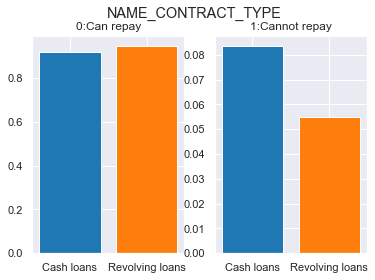

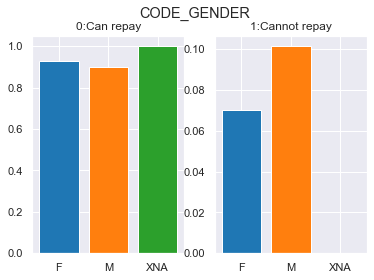

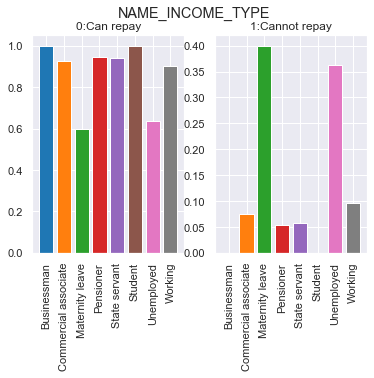

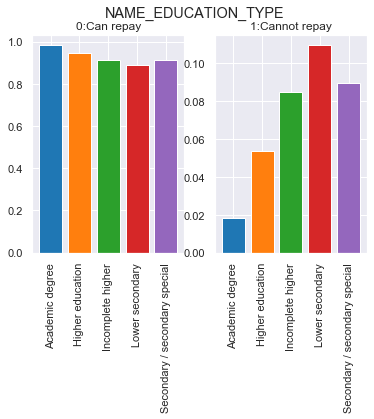

In [19]:
#(Reference)https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda


def str_label_graph(feature):
    """
    string型のデータをもつ特徴量を引数として渡すと、
    その特徴量に含まれるユニークなそれぞれの要素について
    ラベルごとの割り合いをグラフ化する関数
    
    Parameteres
    --------------
    feature: string
        割り合いをグラフ化したい特徴量名
        
    Returns
    --------------
    none
    """
    # 特徴量の各要素の合計数を取得
    temp = df[feature].value_counts()
    df1_temp = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # 大きい順にならぶ(グラフ用)
    # xy_index = pd.DataFrame(temp.index)
    
    # 値で降順で出力されてしまうため、計算用に名前順にする
    df1 = df1_temp.sort_values(feature)
    
    #グラフの軸に使うため、特徴量の要素を保管
    xy_feature = []
    
    # 計算用にnumpyの配列に変換
    xy1_values = []
    for i_df2 in range(len(df1)):
        xy1_values.append(df1.iloc[i_df2,1])
        xy_feature.append(df1.iloc[i_df2,0])
        
    xy1_values_ndarray = np.array(xy1_values)
    
    # ラベル１の要素数を取得（名前順）
    # .groupbyにより、’１’の値を持つデータの合計を取得
    df2 = df[[feature, 'TARGET']].groupby([feature], as_index=False).sum()
    
    # 計算用にnumpyの配列に変換
    xy2_values = []
    for i_df2 in range(len(df2)):
        xy2_values.append(df2.iloc[i_df2,1])
        
    xy2_values_ndarray = np.array(xy2_values)
    

    # ラベル０の要素数を取得（名前順）
    xy3_values_ndarray = xy1_values_ndarray-xy2_values_ndarray
    
    # 各ラベルの比率を計算する
    xy1_ratio = xy2_values_ndarray/xy1_values_ndarray
    xy0_ratio = xy3_values_ndarray/xy1_values_ndarray
    
    # グラフ用に値を入れる
    xy1 = xy0_ratio
    xy2 = xy1_ratio
    # グラフ用に軸名を入れる
    col_xy1 = xy_feature
    col_xy2 = xy_feature

    #グラフ表示
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1) # 1x2の1つめ(左)
    ax2 = fig.add_subplot(1, 2, 2)   # 1x2の2つめ(右)
    
    ax1.set_title('0:Can repay') 
    ax2.set_title('1:Cannot repay') 

    cmap = plt.get_cmap("tab10") 
    
    for n in range(len(xy1)):
        ax1.bar(col_xy1[n],xy1[n], color=cmap(n))
        ax2.bar(col_xy2[n],xy2[n], color=cmap(n))
    
    fig.suptitle(feature)
    
    # ４つ以上の特徴量がある場合、x軸縦書き（９０度回転）
    if len(xy_feature) > 3:
        ax1.set_xticklabels(col_xy1,rotation=90)
        ax2.set_xticklabels(col_xy2,rotation=90)
    
    plt.show()


# column_list = app_train.columns
column_list = [ 'NAME_CONTRACT_TYPE',
                            'CODE_GENDER',
                            'NAME_INCOME_TYPE',
                            'NAME_EDUCATION_TYPE'
                          ]

    
# 文字列データの特徴量を取得
string_column_list = []
for col in range(len(column_list)):
    a = app_train.loc[1][column_list[col]]
    if type(a) == str:
        string_column_list .append(column_list[col])
        
# 各特徴量の比率をグラフで表示
for str_lab in string_column_list:
    str_label_graph(str_lab)
    


In [20]:
feature_list = ['DAYS_BIRTH',
                            'EXT_SOURCE_1',
                            'EXT_SOURCE_2',
                            'EXT_SOURCE_3',
                            'NAME_CONTRACT_TYPE',
                            'CODE_GENDER',
                            'NAME_INCOME_TYPE',
                            'NAME_EDUCATION_TYPE'
                          ]

### ①文字データをワンホットエンコーディングして特徴量に追加

In [21]:
# 読み込んだcsvから必要な特徴量を選んでデータフレームにする
app_train_e1= app_train[feature_list]
app_test_e1= app_test[feature_list]
display(app_train_e1)
display(app_test_e1)
print(app_train_e1.isnull().sum())
print(app_test_e1.isnull().sum())

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE
0,-9461,0.083037,0.262949,0.139376,Cash loans,M,Working,Secondary / secondary special
1,-16765,0.311267,0.622246,NaN,Cash loans,F,State servant,Higher education
2,-19046,NaN,0.555912,0.729567,Revolving loans,M,Working,Secondary / secondary special
3,-19005,NaN,0.650442,NaN,Cash loans,F,Working,Secondary / secondary special
4,-19932,NaN,0.322738,NaN,Cash loans,M,Working,Secondary / secondary special
...,...,...,...,...,...,...,...,...
307506,-9327,0.145570,0.681632,NaN,Cash loans,M,Working,Secondary / secondary special
307507,-20775,NaN,0.115992,NaN,Cash loans,F,Pensioner,Secondary / secondary special
307508,-14966,0.744026,0.535722,0.218859,Cash loans,F,Working,Higher education
307509,-11961,NaN,0.514163,0.661024,Cash loans,F,Commercial associate,Secondary / secondary special


,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE
0,-19241,0.752614,0.789654,0.159520,Cash loans,F,Working,Higher education
1,-18064,0.564990,0.291656,0.432962,Cash loans,M,Working,Secondary / secondary special
2,-20038,0.000000,0.699787,0.610991,Cash loans,M,Working,Higher education
3,-13976,0.525734,0.509677,0.612704,Cash loans,F,Working,Secondary / secondary special
4,-13040,0.202145,0.425687,0.000000,Cash loans,M,Working,Secondary / secondary special
...,...,...,...,...,...,...,...,...
48739,-19970,0.000000,0.648575,0.643026,Cash loans,F,Working,Secondary / secondary special
48740,-11186,0.000000,0.684596,0.000000,Cash loans,F,Commercial associate,Secondary / secondary special
48741,-15922,0.733503,0.632770,0.283712,Cash loans,F,Commercial associate,Secondary / secondary special
48742,-13968,0.373090,0.445701,0.595456,Cash loans,M,Commercial associate,Higher education


DAYS_BIRTH                  0
EXT_SOURCE_1           173378
EXT_SOURCE_2              660
EXT_SOURCE_3            60965
NAME_CONTRACT_TYPE          0
CODE_GENDER                 0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
dtype: int64
DAYS_BIRTH             0
EXT_SOURCE_1           0
EXT_SOURCE_2           0
EXT_SOURCE_3           0
NAME_CONTRACT_TYPE     0
CODE_GENDER            0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
dtype: int64


欠損があることを確認。

#### ラベルエンコーディングの実施

In [22]:
label_e = LabelEncoder()

# Iterate through the columns
for col in column_list:
    
    if app_train_e1[col].dtype == 'object':

        # Train on the training data
        label_e.fit(app_train_e1[col])

        # Transform both training and testing data
        app_train_e1[col] = label_e.transform(app_train_e1[col])
        app_test_e1[col] = label_e.transform(app_test_e1[col])
        print("{}はラベルエンコーディングされました。".format(col))

NAME_CONTRACT_TYPEはラベルエンコーディングされました。
CODE_GENDERはラベルエンコーディングされました。


/Users/ishiitomoaki/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/ishiitomoaki/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


NAME_INCOME_TYPEはラベルエンコーディングされました。
NAME_EDUCATION_TYPEはラベルエンコーディングされました。


In [23]:
# 学習データへ'TARGET'を結合
app_train_e1 = pd.concat([app_train_e1, app_train['TARGET']], axis=1)

### ②文字データをワンホットエンコーディングして特徴量に追加

In [24]:
# 読み込んだcsvから必要な特徴量を選んでデータフレームにする
app_train_e2= app_train[feature_list]
app_test_e2= app_test[feature_list]
display(app_train_e2)
display(app_test_e2)
print(app_train_e2.isnull().sum())
print(app_test_e2.isnull().sum())

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE
0,-9461,0.083037,0.262949,0.139376,Cash loans,M,Working,Secondary / secondary special
1,-16765,0.311267,0.622246,NaN,Cash loans,F,State servant,Higher education
2,-19046,NaN,0.555912,0.729567,Revolving loans,M,Working,Secondary / secondary special
3,-19005,NaN,0.650442,NaN,Cash loans,F,Working,Secondary / secondary special
4,-19932,NaN,0.322738,NaN,Cash loans,M,Working,Secondary / secondary special
...,...,...,...,...,...,...,...,...
307506,-9327,0.145570,0.681632,NaN,Cash loans,M,Working,Secondary / secondary special
307507,-20775,NaN,0.115992,NaN,Cash loans,F,Pensioner,Secondary / secondary special
307508,-14966,0.744026,0.535722,0.218859,Cash loans,F,Working,Higher education
307509,-11961,NaN,0.514163,0.661024,Cash loans,F,Commercial associate,Secondary / secondary special


,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE
0,-19241,0.752614,0.789654,0.159520,Cash loans,F,Working,Higher education
1,-18064,0.564990,0.291656,0.432962,Cash loans,M,Working,Secondary / secondary special
2,-20038,0.000000,0.699787,0.610991,Cash loans,M,Working,Higher education
3,-13976,0.525734,0.509677,0.612704,Cash loans,F,Working,Secondary / secondary special
4,-13040,0.202145,0.425687,0.000000,Cash loans,M,Working,Secondary / secondary special
...,...,...,...,...,...,...,...,...
48739,-19970,0.000000,0.648575,0.643026,Cash loans,F,Working,Secondary / secondary special
48740,-11186,0.000000,0.684596,0.000000,Cash loans,F,Commercial associate,Secondary / secondary special
48741,-15922,0.733503,0.632770,0.283712,Cash loans,F,Commercial associate,Secondary / secondary special
48742,-13968,0.373090,0.445701,0.595456,Cash loans,M,Commercial associate,Higher education


DAYS_BIRTH                  0
EXT_SOURCE_1           173378
EXT_SOURCE_2              660
EXT_SOURCE_3            60965
NAME_CONTRACT_TYPE          0
CODE_GENDER                 0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
dtype: int64
DAYS_BIRTH             0
EXT_SOURCE_1           0
EXT_SOURCE_2           0
EXT_SOURCE_3           0
NAME_CONTRACT_TYPE     0
CODE_GENDER            0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
dtype: int64


欠損があることを確認。

#### ワンホットエンコディング実施の実施

In [25]:
# pd.get_dummiesを使ってワンホットエンコディング実施

app_train_e2 = pd.get_dummies(app_train_e2)
app_test_e2 = pd.get_dummies(app_test_e2)
display(app_train_e2)
display(app_test_e2)
print('Training Features shape: ', app_train_e2.shape)
print('Testing Features shape: ', app_test_e2.shape)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_INCOME_TYPE_Businessman,...,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
0,-9461,0.083037,0.262949,0.139376,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,-16765,0.311267,0.622246,NaN,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,-19046,NaN,0.555912,0.729567,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
3,-19005,NaN,0.650442,NaN,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,-19932,NaN,0.322738,NaN,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-9327,0.145570,0.681632,NaN,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
307507,-20775,NaN,0.115992,NaN,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
307508,-14966,0.744026,0.535722,0.218859,1,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
307509,-11961,NaN,0.514163,0.661024,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
0,-19241,0.752614,0.789654,0.159520,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
1,-18064,0.564990,0.291656,0.432962,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,-20038,0.000000,0.699787,0.610991,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
3,-13976,0.525734,0.509677,0.612704,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4,-13040,0.202145,0.425687,0.000000,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-19970,0.000000,0.648575,0.643026,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
48740,-11186,0.000000,0.684596,0.000000,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
48741,-15922,0.733503,0.632770,0.283712,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
48742,-13968,0.373090,0.445701,0.595456,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0


Training Features shape:  (307511, 22)
Testing Features shape:  (48744, 20)


ワンホットエンコーディングを実施したことで、学習用データとテスト用データの
列数に差ができていることを確認。

In [26]:
for i in app_train_e2.columns:
    if i not in app_test_e2.columns.tolist():
        print(i)

CODE_GENDER_XNA
NAME_INCOME_TYPE_Maternity leave


列が合わないと検証できない為、一致しない行を削除する。

In [27]:
# 一致しない行を削除

train_labels = app_train['TARGET']

print(app_train_e2.shape)

# Align the training and testing data, keep only columns present in both dataframes
app_train_e2, app_test_e2 = app_train_e2.align(app_test_e2, join = 'inner', axis = 1)

print(app_train_e2.shape)



(307511, 22)
(307511, 20)


In [28]:
# 学習データへ'TARGET'を結合
app_train_e2 = pd.concat([app_train_e2, app_train['TARGET']], axis=1)


print('Training Features shape: ', app_train_e2.shape)
print('Testing Features shape: ', app_test_e2.shape)

#print(app_train_e2.columns)
#print(app_test_e2.columns)

Training Features shape:  (307511, 21)
Testing Features shape:  (48744, 20)


### ①の学習と予測を実施

In [29]:
# 学習データの欠損値がある行を削除
display(app_train_e1.isnull().sum())
app_train_e1 = app_train_e1.dropna(how="any")
display(app_train_e1.isnull().sum())

DAYS_BIRTH                  0
EXT_SOURCE_1           173378
EXT_SOURCE_2              660
EXT_SOURCE_3            60965
NAME_CONTRACT_TYPE          0
CODE_GENDER                 0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
TARGET                      0
dtype: int64

DAYS_BIRTH             0
EXT_SOURCE_1           0
EXT_SOURCE_2           0
EXT_SOURCE_3           0
NAME_CONTRACT_TYPE     0
CODE_GENDER            0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
TARGET                 0
dtype: int64

In [30]:
# 学習データをデータとラベルに分割
X_e1 = np.array(app_train_e1[app_train_e1.columns[app_train_e1.columns != 'TARGET']])
y_e1 = np.array(app_train_e1['TARGET'])

In [31]:
# 学習データとテストデータを７５：２５で分割
X_train_e1, X_test_e1, y_train_e1, y_test_e1 = train_test_split(X_e1, y_e1, test_size=0.25, random_state=0)

print(X_train_e1.shape)
print(y_train_e1.shape)
print(X_test_e1.shape)
print(y_test_e1.shape)

(82191, 8)
(82191,)
(27398, 8)
(27398,)


In [32]:
# 標準化クラスをインスタンス化
scaler_e1 = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler_e1.fit(X_train_e1)

# 標準化
X_train_scaled_e1 = scaler_e1.transform(X_train_e1)
X_test_scaled_e1 = scaler_e1.transform(X_test_e1)
#X_te_scaled_e1 = scaler_e1.transform(X_te_e1)

#表示行数を１０行に設定
np.set_printoptions(threshold=10)

print(X_train_scaled_e1)
print(X_test_scaled_e1)
#print(X_te_scaled_e1)

[[ 0.9414237   0.12089212  0.17805643 ...  1.4757421   0.85218485
   0.74474407]
 [ 0.81246831 -0.11377564  0.76685882 ... -0.67754872  0.85218485
   0.74474407]
 [-2.07121013  1.51261204  0.30751971 ... -0.67754872 -0.67546376
   0.74474407]
 ...
 [ 0.92578498 -0.43315546 -0.01019387 ... -0.67754872  0.85218485
   0.74474407]
 [-0.94035081  1.28792554 -0.45127403 ... -0.67754872 -1.43928807
   0.74474407]
 [ 0.59557713  0.34436941  0.5187824  ...  1.4757421  -1.43928807
   0.74474407]]
[[-0.25378512 -1.03959966 -2.64195922 ...  1.4757421   0.85218485
  -1.40813094]
 [-1.6082013   0.31612723 -0.3116659  ... -0.67754872 -0.67546376
   0.74474407]
 [ 0.44406096 -1.7118136  -0.39401592 ...  1.4757421   0.85218485
   0.74474407]
 ...
 [ 0.06129674  0.3719305  -1.45409286 ... -0.67754872  0.85218485
   0.74474407]
 [-0.48734052  0.37369729 -1.65738643 ... -0.67754872  0.85218485
  -1.40813094]
 [ 1.43340263 -1.26291866  1.03717696 ... -0.67754872 -1.43928807
  -1.40813094]]


In [33]:
#ロジスティック回帰

logistic_e1 = LogisticRegression(random_state=0)
logistic_e1.fit(X_train_scaled_e1, y_train_e1)
y_pred_e1 = logistic_e1.predict(X_test_scaled_e1)

In [34]:
label = ['① ラベルエンコーディング']

#Accuracy（正解率）
print("Accuracy（正解率）： {}".format(accuracy_score(y_test_e1, y_pred_e1)))
label .append(accuracy_score(y_test_e1, y_pred_e1))

#Precision（適合率）
print("recision（適合率）： {}".format(precision_score(y_test_e1, y_pred_e1)))
label .append(precision_score(y_test_e1, y_pred_e1))

#Recall（再現率）
print("ecall（再現率）： {}".format(recall_score(y_test_e1, y_pred_e1)))
label .append(recall_score(y_test_e1, y_pred_e1))

#F値
print("F値： {}".format(f1_score(y_test_e1, y_pred_e1)))
label .append(f1_score(y_test_e1, y_pred_e1))

print("混同行列：\n{}".format(confusion_matrix(y_test_e1, y_pred_e1)))
label_matrix = confusion_matrix(y_test_e1, y_pred_e1)

Accuracy（正解率）： 0.926855974888678
recision（適合率）： 0.6153846153846154
ecall（再現率）： 0.007960199004975124
F値： 0.015717092337917484
混同行列：
[[25378    10]
 [ 1994    16]]


### ②の学習と予測を実施

In [35]:
# 学習データの欠損値がある行を削除
display(app_train_e2.isnull().sum())
app_train_e2 = app_train_e2.dropna(how="any")
display(app_train_e2.isnull().sum())

DAYS_BIRTH                                                0
EXT_SOURCE_1                                         173378
EXT_SOURCE_2                                            660
EXT_SOURCE_3                                          60965
NAME_CONTRACT_TYPE_Cash loans                             0
NAME_CONTRACT_TYPE_Revolving loans                        0
CODE_GENDER_F                                             0
CODE_GENDER_M                                             0
NAME_INCOME_TYPE_Businessman                              0
NAME_INCOME_TYPE_Commercial associate                     0
NAME_INCOME_TYPE_Pensioner                                0
NAME_INCOME_TYPE_State servant                            0
NAME_INCOME_TYPE_Student                                  0
NAME_INCOME_TYPE_Unemployed                               0
NAME_INCOME_TYPE_Working                                  0
NAME_EDUCATION_TYPE_Academic degree                       0
NAME_EDUCATION_TYPE_Higher education    

DAYS_BIRTH                                           0
EXT_SOURCE_1                                         0
EXT_SOURCE_2                                         0
EXT_SOURCE_3                                         0
NAME_CONTRACT_TYPE_Cash loans                        0
NAME_CONTRACT_TYPE_Revolving loans                   0
CODE_GENDER_F                                        0
CODE_GENDER_M                                        0
NAME_INCOME_TYPE_Businessman                         0
NAME_INCOME_TYPE_Commercial associate                0
NAME_INCOME_TYPE_Pensioner                           0
NAME_INCOME_TYPE_State servant                       0
NAME_INCOME_TYPE_Student                             0
NAME_INCOME_TYPE_Unemployed                          0
NAME_INCOME_TYPE_Working                             0
NAME_EDUCATION_TYPE_Academic degree                  0
NAME_EDUCATION_TYPE_Higher education                 0
NAME_EDUCATION_TYPE_Incomplete higher                0
NAME_EDUCA

In [36]:
# 学習データをデータとラベルに分割
X_e2 = np.array(app_train_e2[app_train_e2.columns[app_train_e2.columns != 'TARGET']])
y_e2 = np.array(app_train_e2['TARGET'])

In [37]:
# 学習データとテストデータを７５：２５で分割
X_train_e2, X_test_e2, y_train_e2, y_test_e2 = train_test_split(X_e2, y_e2, test_size=0.25, random_state=0)

print(X_train_e2.shape)
print(y_train_e2.shape)
print(X_test_e2.shape)
print(y_test_e2.shape)

(82191, 20)
(82191,)
(27398, 20)
(27398,)


In [38]:
# 標準化クラスをインスタンス化
scaler_e2 = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler_e2.fit(X_train_e2)

# 標準化
X_train_scaled_e2 = scaler_e2.transform(X_train_e2)
X_test_scaled_e2 = scaler_e2.transform(X_test_e2)
#X_te_scaled_e2 = scaler_e2.transform(X_te_e2)

#表示行数を１０行に設定
np.set_printoptions(threshold=10)

print(X_train_scaled_e2)
print(X_test_scaled_e2)
#print(X_te_scaled_e2)

[[ 0.9414237   0.12089212  0.17805643 ... -0.20750776 -0.08582598
   0.75708919]
 [ 0.81246831 -0.11377564  0.76685882 ... -0.20750776 -0.08582598
   0.75708919]
 [-2.07121013  1.51261204  0.30751971 ... -0.20750776 -0.08582598
   0.75708919]
 ...
 [ 0.92578498 -0.43315546 -0.01019387 ... -0.20750776 -0.08582598
   0.75708919]
 [-0.94035081  1.28792554 -0.45127403 ... -0.20750776 -0.08582598
   0.75708919]
 [ 0.59557713  0.34436941  0.5187824  ... -0.20750776 -0.08582598
   0.75708919]]
[[-0.25378512 -1.03959966 -2.64195922 ... -0.20750776 -0.08582598
  -1.32084835]
 [-1.6082013   0.31612723 -0.3116659  ... -0.20750776 -0.08582598
   0.75708919]
 [ 0.44406096 -1.7118136  -0.39401592 ... -0.20750776 -0.08582598
   0.75708919]
 ...
 [ 0.06129674  0.3719305  -1.45409286 ... -0.20750776 -0.08582598
   0.75708919]
 [-0.48734052  0.37369729 -1.65738643 ... -0.20750776 -0.08582598
  -1.32084835]
 [ 1.43340263 -1.26291866  1.03717696 ... -0.20750776 -0.08582598
  -1.32084835]]


In [39]:
#ロジスティック回帰

logistic_e2 = LogisticRegression(random_state=0)
logistic_e2.fit(X_train_scaled_e2, y_train_e2)
y_pred_e2 = logistic_e2.predict(X_test_scaled_e2)

In [40]:
one_hot = ['②ワンホットエンコーディング']

#Accuracy（正解率）
print("Accuracy（正解率）： {}".format(accuracy_score(y_test_e2, y_pred_e2)))
one_hot.append(accuracy_score(y_test_e2, y_pred_e2))

#Precision（適合率）
print("recision（適合率）： {}".format(precision_score(y_test_e2, y_pred_e2)))
one_hot.append(precision_score(y_test_e2, y_pred_e2))

#Recall（再現率）
print("ecall（再現率）： {}".format(recall_score(y_test_e2, y_pred_e2)))
one_hot.append(recall_score(y_test_e2, y_pred_e2))

#F値
print("F値： {}".format(f1_score(y_test_e2, y_pred_e2)))
one_hot.append(f1_score(y_test_e2, y_pred_e2))


print("混同行列：\n{}".format(confusion_matrix(y_test_e2, y_pred_e2)))
one_hot_matrix = confusion_matrix(y_test_e2, y_pred_e2)

Accuracy（正解率）： 0.9268924739032046
recision（適合率）： 0.64
ecall（再現率）： 0.007960199004975124
F値： 0.015724815724815724
混同行列：
[[25379     9]
 [ 1994    16]]


### ③エンコーディングした上でTARGETとの相関性が高いものを見つけて特徴量とする  

すべての文字データに対してユニークなカテゴリが２以下のものをターゲットエンコーディング、 ２より大きいものをワンホットエンコーディングする。

In [41]:
# 読み込んだcsvから必要な特徴量を選んでデータフレームにする
app_train_e3= app_train
app_test_e3= app_test
display(app_train_e3)
display(app_test_e3)
print(app_train_e3.isnull().sum())
print(app_test_e3.isnull().sum())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
SK_ID_CURR                    0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 121, dtype: int64


In [42]:
# 文字列データの特徴量を取得
column_list_e3 = app_train_e3.columns
string_column_list = []
for col in column_list_e3:
    if app_train_e3[col].dtype == object:
        string_column_list .append(col)
print(string_column_list)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [43]:
# 文字データの特徴量を抜き出す
corr_train_e3= app_train_e3[string_column_list]
corr_test_e3= app_test_e3[string_column_list]
display(corr_train_e3)
display(corr_test_e3)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,0,TUESDAY,Kindergarten,0,block of flats,"Stone, brick",No
1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,FRIDAY,Self-employed,0,0,0,0
2,Cash loans,M,Y,Y,0,Working,Higher education,Married,House / apartment,Drivers,MONDAY,Transport: type 3,0,0,0,0
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
4,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0,FRIDAY,Business Entity Type 3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,0,WEDNESDAY,Other,0,0,0,0
48740,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,MONDAY,Trade: type 7,0,0,0,0
48741,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0,WEDNESDAY,Business Entity Type 3,0,block of flats,"Stone, brick",No
48742,Cash loans,M,N,N,Family,Commercial associate,Higher education,Married,House / apartment,Managers,MONDAY,Self-employed,0,block of flats,Panel,No


In [44]:
# 各特徴量が含んでいる要素の数を確認
corr_train_e3.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

2つの一意のカテゴリを持つカテゴリ変数（dtype ==オブジェクト）にはラベルエンコーディングを使用し、3つ以上の一意のカテゴリを持つカテゴリ変数にはワンホットエンコーディングを使用。

In [45]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in corr_train_e3:
    
    if corr_train_e3[col].dtype == 'object':
    
        # If 2 or fewer unique categories
        if len(list(corr_train_e3[col].unique())) <= 2:
            # Train on the training data
            le.fit(corr_train_e3[col])
            
            # Transform both training and testing data
            corr_train_e3[col] = le.transform(corr_train_e3[col])
            corr_test_e3[col] = le.transform(corr_test_e3[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

/Users/ishiitomoaki/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/ishiitomoaki/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


3 columns were label encoded.


In [46]:
# 各特徴量が含んでいる要素の数を確認
corr_train_e3.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CODE_GENDER                    3
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

EMERGENCYSTATE_MODEはnan値を含んでいる為、ラベルエンコーディング処理されなかった。

In [47]:
app_train['EMERGENCYSTATE_MODE'].unique()

array(['No', nan, 'Yes'], dtype=object)

In [48]:
# pd.get_dummiesを使ってワンホットエンコディング実施

corr_train_e3 = pd.get_dummies(corr_train_e3)
corr_test_e3 = pd.get_dummies(corr_test_e3)

print('Training Features shape: ', corr_train_e3.shape)
print('Testing Features shape: ', corr_test_e3.shape)

Training Features shape:  (307511, 137)
Testing Features shape:  (48744, 140)


ワンホットエンコーディングによって行数がどう変わったか確認

In [49]:
for i in app_train_e3.columns:
    if i not in app_test_e3.columns.tolist():
        print(i)

TARGET


テストデータに存在しない特徴量（エンコーディングによって作成された余計な行）は削除する

In [50]:
# Align the training and testing data, keep only columns present in both dataframes
corr_train_e3, corr_test_e3 = corr_train_e3.align(corr_test_e3, join = 'inner', axis = 1)

print(corr_train_e3.shape)

(307511, 134)


TARGETを追加

In [51]:
# Add the target back in
corr_train_e3 = pd.concat([corr_train_e3, app_train['TARGET']], axis=1)

print('Training Features shape: ', corr_train_e3.shape)
print('Testing Features shape: ', corr_test_e3.shape)

Training Features shape:  (307511, 135)
Testing Features shape:  (48744, 134)


In [52]:
for i in app_train.columns:
    if i not in app_test.columns.tolist():
        print(i)

TARGET


文字データの中で'TARGET'との相関性が高いものを選んで特徴量とする。

In [53]:
# 相関係数の計算
corr = corr_train_e3.corr()['TARGET'].sort_values()


pd.set_option('display.max_rows', 150)
display(corr)

NAME_EDUCATION_TYPE_Higher education                -0.056593
CODE_GENDER_F                                       -0.054704
NAME_INCOME_TYPE_Pensioner                          -0.046209
ORGANIZATION_TYPE_XNA                               -0.045987
EMERGENCYSTATE_MODE_No                              -0.042201
HOUSETYPE_MODE_block of flats                       -0.040594
WALLSMATERIAL_MODE_Panel                            -0.033119
NAME_CONTRACT_TYPE                                  -0.030896
NAME_HOUSING_TYPE_House / apartment                 -0.028555
NAME_FAMILY_STATUS_Married                          -0.025043
NAME_INCOME_TYPE_State servant                      -0.023447
FONDKAPREMONT_MODE_reg oper account                 -0.022587
FLAG_OWN_CAR                                        -0.021851
OCCUPATION_TYPE_Accountants                         -0.021610
OCCUPATION_TYPE_Core staff                          -0.020378
NAME_FAMILY_STATUS_Widow                            -0.019394
OCCUPATI

相関性上位５件は以下の通り。  

- NAME_INCOME_TYPE_Working                             0.057481
- CODE_GENDER_M                                        0.054713
- NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
- OCCUPATION_TYPE_Laborers                             0.043019
- OCCUPATION_TYPE_Drivers                              0.030303

In [54]:
# ベースラインの特徴量を抜き出す
feature_list_base = ['DAYS_BIRTH',
                            'EXT_SOURCE_1',
                            'EXT_SOURCE_2',
                            'EXT_SOURCE_3'                            
                          ]

app_train_e3 = app_train_e3[feature_list_base]
print(app_train_e3)

        DAYS_BIRTH  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3
0            -9461      0.083037      0.262949      0.139376
1           -16765      0.311267      0.622246           NaN
2           -19046           NaN      0.555912      0.729567
3           -19005           NaN      0.650442           NaN
4           -19932           NaN      0.322738           NaN
...            ...           ...           ...           ...
307506       -9327      0.145570      0.681632           NaN
307507      -20775           NaN      0.115992           NaN
307508      -14966      0.744026      0.535722      0.218859
307509      -11961           NaN      0.514163      0.661024
307510      -16856      0.734460      0.708569      0.113922

[307511 rows x 4 columns]


In [55]:
# 文字データのうちTARGET との相関が高かった特徴量を抜き出す
features = ['NAME_INCOME_TYPE_Working',
            'CODE_GENDER_M',
            'NAME_EDUCATION_TYPE_Secondary / secondary special',
            'OCCUPATION_TYPE_Laborers',
            'OCCUPATION_TYPE_Drivers']

# ベースラインの特徴量に追加する。
app_train_e3 = pd.concat([app_train_e3, corr_train_e3[features]], axis=1)

# TARGET を追加
app_train_e3 = pd.concat([app_train_e3, corr_train_e3['TARGET']], axis=1)

In [56]:
# 学習データの欠損値がある行を削除
display(app_train_e3.isnull().sum())
app_train_e3 = app_train_e3.dropna(how="any")
display(app_train_e3.isnull().sum())

DAYS_BIRTH                                                0
EXT_SOURCE_1                                         173378
EXT_SOURCE_2                                            660
EXT_SOURCE_3                                          60965
NAME_INCOME_TYPE_Working                                  0
CODE_GENDER_M                                             0
NAME_EDUCATION_TYPE_Secondary / secondary special         0
OCCUPATION_TYPE_Laborers                                  0
OCCUPATION_TYPE_Drivers                                   0
TARGET                                                    0
dtype: int64

DAYS_BIRTH                                           0
EXT_SOURCE_1                                         0
EXT_SOURCE_2                                         0
EXT_SOURCE_3                                         0
NAME_INCOME_TYPE_Working                             0
CODE_GENDER_M                                        0
NAME_EDUCATION_TYPE_Secondary / secondary special    0
OCCUPATION_TYPE_Laborers                             0
OCCUPATION_TYPE_Drivers                              0
TARGET                                               0
dtype: int64

In [57]:
# 学習データをデータとラベルに分割
X_e3 = np.array(app_train_e3[app_train_e3.columns[app_train_e3.columns != 'TARGET']])
y_e3 = np.array(app_train_e3['TARGET'])

print(X_e3)
print(y_e3)

[[-9.46100000e+03  8.30369674e-02  2.62948593e-01 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-1.37780000e+04  7.74761413e-01  7.23999852e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.00990000e+04  5.87334047e-01  2.05747288e-01 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-1.18700000e+04  2.43465848e-01  5.01220999e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.49660000e+04  7.44026400e-01  5.35721752e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.68560000e+04  7.34459669e-01  7.08568896e-01 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]]
[1 0 0 ... 0 0 0]


In [58]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータを７５：２５で分割
X_train_e3, X_test_e3, y_train_e3, y_test_e3 = train_test_split(X_e3, y_e3, test_size=0.25, random_state=0)

print(X_train_e3.shape)
print(y_train_e3.shape)
print(X_test_e3.shape)
print(y_test_e3.shape)

(82191, 9)
(82191,)
(27398, 9)
(27398,)


In [59]:
from sklearn.preprocessing import StandardScaler

# 標準化クラスをインスタンス化
scaler_e3 = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler_e3.fit(X_train_e3)

# 標準化
X_train_scaled_e3 = scaler_e3.transform(X_train_e3)
X_test_scaled_e3 = scaler_e3.transform(X_test_e3)

#表示行数を１０行に設定
np.set_printoptions(threshold=10)

print(X_train_scaled_e3)
print(X_test_scaled_e3)

[[ 0.9414237   0.12089212  0.17805643 ...  0.75708919 -0.46323373
   4.30489045]
 [ 0.81246831 -0.11377564  0.76685882 ...  0.75708919 -0.46323373
  -0.23229395]
 [-2.07121013  1.51261204  0.30751971 ...  0.75708919 -0.46323373
  -0.23229395]
 ...
 [ 0.92578498 -0.43315546 -0.01019387 ...  0.75708919  2.15873745
  -0.23229395]
 [-0.94035081  1.28792554 -0.45127403 ...  0.75708919  2.15873745
  -0.23229395]
 [ 0.59557713  0.34436941  0.5187824  ...  0.75708919  2.15873745
  -0.23229395]]
[[-0.25378512 -1.03959966 -2.64195922 ... -1.32084835 -0.46323373
  -0.23229395]
 [-1.6082013   0.31612723 -0.3116659  ...  0.75708919 -0.46323373
  -0.23229395]
 [ 0.44406096 -1.7118136  -0.39401592 ...  0.75708919 -0.46323373
  -0.23229395]
 ...
 [ 0.06129674  0.3719305  -1.45409286 ...  0.75708919 -0.46323373
  -0.23229395]
 [-0.48734052  0.37369729 -1.65738643 ... -1.32084835 -0.46323373
  -0.23229395]
 [ 1.43340263 -1.26291866  1.03717696 ... -1.32084835 -0.46323373
  -0.23229395]]


In [60]:
#ロジスティック回帰

logistic_e3 = LogisticRegression(random_state=0)
logistic_e3.fit(X_train_scaled_e3, y_train_e3)
y_pred_e3 = logistic_e3.predict(X_test_scaled_e3)

In [61]:
label_one_hot  = ['③ラベル＆ワンホット']

#Accuracy（正解率）
print("Accuracy（正解率）： {}".format(accuracy_score(y_test_e3, y_pred_e3)))
label_one_hot.append(accuracy_score(y_test_e3, y_pred_e3))

#Precision（適合率）
print("recision（適合率）： {}".format(precision_score(y_test_e3, y_pred_e3)))
label_one_hot.append(precision_score(y_test_e3, y_pred_e3))

#Recall（再現率）
print("ecall（再現率）： {}".format(recall_score(y_test_e3, y_pred_e3)))
label_one_hot.append(recall_score(y_test_e3, y_pred_e3))

#F値
print("F値： {}".format(f1_score(y_test_e3, y_pred_e3)))
label_one_hot.append(f1_score(y_test_e3, y_pred_e3))


print("混同行列：\n{}".format(confusion_matrix(y_test_e3, y_pred_e3)))
label_one_hot_matrix = confusion_matrix(y_test_e3, y_pred_e3)

Accuracy（正解率）： 0.9268194758741514
recision（適合率）： 0.6086956521739131
ecall（再現率）： 0.006965174129353234
F値： 0.013772749631087062
混同行列：
[[25379     9]
 [ 1996    14]]


### ④数値データにビニングを試す

In [62]:
# ベースラインと同じデータフレームを用意

# sickit-learnに入れるために特徴量をX_bin、目的変数をy_binというndarrayに格納
X_bin = np.array(df_drop.loc[:,['DAYS_BIRTH','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])
y_bin = np.array(df_drop.loc[:,'TARGET'])

# 回答作成用のテストデータを用意
X_te_bin = np.array(df2_t.loc[:,['DAYS_BIRTH','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])

In [63]:
# ビニング用のビンを用意するために各特徴量の最小値、最大値を確認
print(np.max(X_bin, axis=0))
print(np.min(X_bin, axis=0))

[-7.68000000e+03  9.62692771e-01  8.54999666e-01  8.87664202e-01]
[-2.52010000e+04  1.45681324e-02  1.31595558e-06  5.27265239e-04]


In [64]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression


X = X_bin[:,0].reshape(-1,1)

#  -30000から-8000の間に２０００このビン（入れ物）を作る。
bins = np.linspace(-30000, -8000, 2001)
#  Xの中の値を該当するビンに入れる。
which_bin = np.digitize(X, bins=bins)

# ワンホットエンコーディングで数値が入っている瓶の数分の特徴量を作成。
encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
X_binned1 = encoder.transform(which_bin)


X = X_bin[:,1].reshape(-1,1)

#  ０から１の間に２０００このビン（入れ物）を作る。
bins = np.linspace(0, 1, 2001)
#  Xの中の値を該当するビンに入れる。
which_bin = np.digitize(X, bins=bins)

# ワンホットエンコーディングで数値が入っている瓶の数分の特徴量を作成。
encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
X_binned2 = encoder.transform(which_bin)


X = X_bin[:,2].reshape(-1,1)

#  ０から１の間に２０００このビン（入れ物）を作る。
bins = np.linspace(0, 1, 2001)
#  Xの中の値を該当するビンに入れる。
which_bin = np.digitize(X, bins=bins)

# ワンホットエンコーディングで数値が入っている瓶の数分の特徴量を作成。
encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
X_binned3 = encoder.transform(which_bin)


X = X_bin[:,3].reshape(-1,1)

#  ０から１の間に２０００このビン（入れ物）を作る。
bins = np.linspace(0, 1, 2001)
#  Xの中の値を該当するビンに入れる。
which_bin = np.digitize(X, bins=bins)

# ワンホットエンコーディングで数値が入っている瓶の数分の特徴量を作成。
encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
X_binned4 = encoder.transform(which_bin)

# 作成した新しい特徴量を結合
X_binned = np.concatenate((X_binned1, X_binned2, X_binned3, X_binned4), axis=1)
print(X_binned.shape)
print(X_binned)

(109589, 5782)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


テスト用データにもビニングを実施

In [65]:
# ビニング用のビンを用意するために各特徴量の最小値、最大値を確認
print(np.max(X_te_bin, axis=0))
print(np.min(X_te_bin, axis=0))

[-7.33800000e+03  9.39144533e-01  8.54999666e-01  8.82530313e-01]
[-25195.      0.      0.      0.]


In [66]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression


X = X_te_bin[:,0].reshape(-1,1)

#  -30000から-8000の間に２０００このビン（入れ物）を作る。
bins = np.linspace(-30000, -8000, 2001)
#  Xの中の値を該当するビンに入れる。
which_bin = np.digitize(X, bins=bins)

# ワンホットエンコーディングで数値が入っている瓶の数分の特徴量を作成。
encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
X_binned1 = encoder.transform(which_bin)

X = X_te_bin[:,1].reshape(-1,1)

#  ０から１の間に２０００このビン（入れ物）を作る。
bins = np.linspace(0, 1, 2001)
#  Xの中の値を該当するビンに入れる。
which_bin = np.digitize(X, bins=bins)

# ワンホットエンコーディングで数値が入っている瓶の数分の特徴量を作成。
encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
X_binned2 = encoder.transform(which_bin)


X = X_te_bin[:,2].reshape(-1,1)

#  ０から１の間に２０００このビン（入れ物）を作る。
bins = np.linspace(0, 1, 2001)
#  Xの中の値を該当するビンに入れる。
which_bin = np.digitize(X, bins=bins)

# ワンホットエンコーディングで数値が入っている瓶の数分の特徴量を作成。
encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
X_binned3 = encoder.transform(which_bin)


X = X_te_bin[:,3].reshape(-1,1)

#  ０から１の間に２０００このビン（入れ物）を作る。
bins = np.linspace(0, 1, 2001)
#  Xの中の値を該当するビンに入れる。
which_bin = np.digitize(X, bins=bins)

# ワンホットエンコーディングで数値が入っている瓶の数分の特徴量を作成。
encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
X_binned4 = encoder.transform(which_bin)


# 作成した新しい特徴量を結合
X_binned_test = np.concatenate((X_binned1, X_binned2, X_binned3, X_binned4), axis=1)
print(X_binned_test.shape)
print(X_binned_test)

(48744, 5647)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [67]:
# 学習データをデータとラベルに分割
X_binned = pd.DataFrame(X_binned)
X_binned_test = pd.DataFrame(X_binned_test)
X_binned, X_binned_test = X_binned.align(X_binned_test, join = 'inner', axis = 1)

print(X_binned.shape)
print(X_binned_test.shape)

(109589, 5647)
(48744, 5647)


In [68]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータを７５：２５で分割
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binned, y_bin, test_size=0.25, random_state=0)

print(X_train_bin.shape)
print(y_train_bin.shape)
print(X_test_bin.shape)
print(y_test_bin.shape)


(82191, 5647)
(82191,)
(27398, 5647)
(27398,)


In [69]:
from sklearn.preprocessing import StandardScaler

# 標準化クラスをインスタンス化
scaler_bin = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler_bin.fit(X_train_bin)

# 標準化
X_train_scaled_bin = scaler_bin.transform(X_train_bin)
X_test_scaled_bin = scaler_bin.transform(X_test_bin)
X_te_scaled_bin = scaler_bin.transform(X_binned_test)
#X_binned_scaled = scaler_bin.transform(X_binned)

#表示行数を１０行に設定
np.set_printoptions(threshold=10)

print(X_train_scaled_bin)
print(X_test_scaled_bin)
print(X_te_scaled_bin)
#print(X_binned_scaled)


[[-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 ...
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]]
[[-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 ...
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]
 [-0.00348811 -0.00604166 -0.00493297 ... -0.04938919 -0.04926526
  -0.04416426]]
[[-0.00348811 -0

In [70]:
#ロジスティック回帰


# デフォルトのイテレーション数(100)では「OTAL NO. of ITERATIONS REACHED LIMIT」との
# メッセージが出て学習が終わらないのでmax_iter=５0000。（ベースラインは特徴量の１０倍程度の為）
logistic_bin = LogisticRegression(random_state=0, max_iter=50000)
logistic_bin.fit(X_train_scaled_bin, y_train_bin)
y_pred_bin = logistic_bin.predict(X_test_scaled_bin)


In [71]:
binning = ['④ビニング']

#Accuracy（正解率）
print("Accuracy（正解率）： {}".format(accuracy_score(y_test_bin, y_pred_bin)))
binning.append(accuracy_score(y_test_bin, y_pred_bin))

#Precision（適合率）
print("recision（適合率）： {}".format(precision_score(y_test_bin, y_pred_bin)))
binning.append(precision_score(y_test_bin, y_pred_bin))

#Recall（再現率）
print("ecall（再現率）： {}".format(recall_score(y_test_bin, y_pred_bin)))
binning.append(recall_score(y_test_bin, y_pred_bin))

#F値
print("F値： {}".format(f1_score(y_test_bin, y_pred_bin)))
binning.append(f1_score(y_test_bin, y_pred_bin))


print("混同行列：\n{}".format(confusion_matrix(y_test_bin, y_pred_bin)))
binning_matrix = confusion_matrix(y_test_bin, y_pred_bin)




Accuracy（正解率）： 0.9172932330827067
recision（適合率）： 0.23877551020408164
ecall（再現率）： 0.058208955223880594
F値： 0.09359999999999999
混同行列：
[[25015   373]
 [ 1893   117]]


### ⑤意味のある特徴量を新規作成する

- DAYS_BIRTHは「申請時のクライアントの年齢（日数）」のデータであるが、  
年齢は年単位で見たいので、年に変換する必要がある。また、マイナス値になっている為、  
プラスに変換する必要がある。

- 銀行は企業向けに貸し付ける際インタレスト・カバレッジ・レシオなどの評価指標を用いている（単純化すると営業利益÷支払利息）。  
個人向け貸付の指標ではないが、「収入ー支出」と「利息」の比率などの指標を算出して利用すれば意味のあるモデル構築ができるのではないかと思われる。  
しかし、今回の課題の「application_test.csv」に「支出」や「利息」のデータがない為、「収入」と「ローン額」の比率を計算して安全指標の代替手段とする。

In [72]:
# 読み込んだcsvから必要な特徴量を選んでデータフレームにする
app_train_expert= app_train[['TARGET','DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
app_test_expert= app_test[['DAYS_BIRTH','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
display(app_train_expert)
display(app_test_expert)
print(app_train_expert.isnull().sum())
print(app_test_expert.isnull().sum())

,TARGET,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,-9461,0.083037,0.262949,0.139376
1,0,-16765,0.311267,0.622246,NaN
2,0,-19046,NaN,0.555912,0.729567
3,0,-19005,NaN,0.650442,NaN
4,0,-19932,NaN,0.322738,NaN
...,...,...,...,...,...
307506,0,-9327,0.145570,0.681632,NaN
307507,0,-20775,NaN,0.115992,NaN
307508,0,-14966,0.744026,0.535722,0.218859
307509,1,-11961,NaN,0.514163,0.661024


,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,-19241,0.752614,0.789654,0.159520
1,-18064,0.564990,0.291656,0.432962
2,-20038,0.000000,0.699787,0.610991
3,-13976,0.525734,0.509677,0.612704
4,-13040,0.202145,0.425687,0.000000
...,...,...,...,...
48739,-19970,0.000000,0.648575,0.643026
48740,-11186,0.000000,0.684596,0.000000
48741,-15922,0.733503,0.632770,0.283712
48742,-13968,0.373090,0.445701,0.595456


TARGET               0
DAYS_BIRTH           0
EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64
DAYS_BIRTH      0
EXT_SOURCE_1    0
EXT_SOURCE_2    0
EXT_SOURCE_3    0
dtype: int64


In [73]:
# 年齢を日数から年単位に変換する
print(app_train_expert['DAYS_BIRTH'])
app_train_expert['DAYS_BIRTH'] = abs(app_train_expert['DAYS_BIRTH'])/365
print(app_train_expert['DAYS_BIRTH'])

print(app_test_expert['DAYS_BIRTH'])
app_test_expert['DAYS_BIRTH'] = abs(app_test_expert['DAYS_BIRTH'])/365
print(app_test_expert['DAYS_BIRTH'])

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length: 307511, dtype: int64
0         25.920548
1         45.931507
2         52.180822
3         52.068493
4         54.608219
            ...    
307506    25.553425
307507    56.917808
307508    41.002740
307509    32.769863
307510    46.180822
Name: DAYS_BIRTH, Length: 307511, dtype: float64
0       -19241
1       -18064
2       -20038
3       -13976
4       -13040
         ...  
48739   -19970
48740   -11186
48741   -15922
48742   -13968
48743   -13962
Name: DAYS_BIRTH, Length: 48744, dtype: int64
0        52.715068
1        49.490411
2        54.898630
3        38.290411
4        35.726027
           ...    
48739    54.712329
48740    30.646575
48741    43.621918
48742    38.268493
48743    38.252055
Name: DAYS_BIRTH, Length: 48744, dtype: float64


/Users/ishiitomoaki/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ishiitomoaki/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [74]:
# 収入の列と借入の列を抜き出す
app_train_income = app_train[['AMT_INCOME_TOTAL']]
app_train_credit = app_train[['AMT_CREDIT']]
app_test_income = app_test[['AMT_INCOME_TOTAL']]
app_test_credit = app_test[['AMT_CREDIT']]

print(app_train_income)
print(app_train_credit)

# 収入と借入の比率を計算し、データフレームに変換する
app_train_ratio = np.array(app_train_income)/np.array(app_train_credit)
app_test_ratio = np.array(app_test_income)/np.array(app_test_credit)

df_train_ratio = pd.DataFrame(app_train_ratio, columns=['INCOME_CREDIT_RATIO'])
df_test_ratio = pd.DataFrame(app_test_ratio, columns=['INCOME_CREDIT_RATIO'])

print(df_train_ratio)
print(df_test_ratio)

        AMT_INCOME_TOTAL
0               202500.0
1               270000.0
2                67500.0
3               135000.0
4               121500.0
...                  ...
307506          157500.0
307507           72000.0
307508          153000.0
307509          171000.0
307510          157500.0

[307511 rows x 1 columns]
        AMT_CREDIT
0         406597.5
1        1293502.5
2         135000.0
3         312682.5
4         513000.0
...            ...
307506    254700.0
307507    269550.0
307508    677664.0
307509    370107.0
307510    675000.0

[307511 rows x 1 columns]
        INCOME_CREDIT_RATIO
0                  0.498036
1                  0.208736
2                  0.500000
3                  0.431748
4                  0.236842
...                     ...
307506             0.618375
307507             0.267112
307508             0.225776
307509             0.462029
307510             0.233333

[307511 rows x 1 columns]
       INCOME_CREDIT_RATIO
0                 0.237342
1

In [75]:
# 作成した収入-借入比率をデータフレームに追加する
app_train_expert = pd.concat([app_train_expert, df_train_ratio], axis=1)
app_test_expert = pd.concat([app_test_expert, df_test_ratio], axis=1)
display(app_train_expert)
display(app_test_expert)

,TARGET,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INCOME_CREDIT_RATIO
0,1,25.920548,0.083037,0.262949,0.139376,0.498036
1,0,45.931507,0.311267,0.622246,NaN,0.208736
2,0,52.180822,NaN,0.555912,0.729567,0.500000
3,0,52.068493,NaN,0.650442,NaN,0.431748
4,0,54.608219,NaN,0.322738,NaN,0.236842
...,...,...,...,...,...,...
307506,0,25.553425,0.145570,0.681632,NaN,0.618375
307507,0,56.917808,NaN,0.115992,NaN,0.267112
307508,0,41.002740,0.744026,0.535722,0.218859,0.225776
307509,1,32.769863,NaN,0.514163,0.661024,0.462029


,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INCOME_CREDIT_RATIO
0,52.715068,0.752614,0.789654,0.159520,0.237342
1,49.490411,0.564990,0.291656,0.432962,0.444409
2,54.898630,0.000000,0.699787,0.610991,0.305308
3,38.290411,0.525734,0.509677,0.612704,0.200000
4,35.726027,0.202145,0.425687,0.000000,0.287770
...,...,...,...,...,...
48739,54.712329,0.000000,0.648575,0.643026,0.294503
48740,30.646575,0.000000,0.684596,0.000000,0.253047
48741,43.621918,0.733503,0.632770,0.283712,0.642857
48742,38.268493,0.373090,0.445701,0.595456,0.500000


In [76]:
# 学習データの欠損値がある行を削除
display(app_train_expert.isnull().sum())
app_train_expert = app_train_expert.dropna(how="any")
display(app_train_expert.isnull().sum())

TARGET                      0
DAYS_BIRTH                  0
EXT_SOURCE_1           173378
EXT_SOURCE_2              660
EXT_SOURCE_3            60965
INCOME_CREDIT_RATIO         0
dtype: int64

TARGET                 0
DAYS_BIRTH             0
EXT_SOURCE_1           0
EXT_SOURCE_2           0
EXT_SOURCE_3           0
INCOME_CREDIT_RATIO    0
dtype: int64

In [77]:
# 学習データをデータとラベルに分割
X_ex = np.array(app_train_expert[app_train_expert.columns[app_train_expert.columns != 'TARGET']])
y_ex = np.array(app_train_expert['TARGET'])

In [78]:
# 学習データとテストデータを７５：２５で分割
X_train_ex, X_test_ex, y_train_ex, y_test_ex = train_test_split(X_ex, y_ex, test_size=0.25, random_state=0)

print(X_train_ex.shape)
print(y_train_ex.shape)
print(X_test_ex.shape)
print(y_test_ex.shape)


(82191, 5)
(82191,)
(27398, 5)
(27398,)


In [79]:
# 標準化クラスをインスタンス化
scaler_ex = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler_ex.fit(X_train_ex)

# 標準化
X_train_scaled_ex = scaler_ex.transform(X_train_ex)
X_test_scaled_ex = scaler_ex.transform(X_test_ex)
#X_te_scaled_ex = scaler_ex.transform(X_te_ex)

#表示行数を１０行に設定
np.set_printoptions(threshold=10)

print(X_train_scaled_ex)
print(X_test_scaled_ex)
#print(X_te_scaled_ex)

[[-0.9414237   0.12089212  0.17805643 -0.54442099  0.02053387]
 [-0.81246831 -0.11377564  0.76685882 -0.36505365 -0.31389973]
 [ 2.07121013  1.51261204  0.30751971 -1.3924383  -0.24005843]
 ...
 [-0.92578498 -0.43315546 -0.01019387 -1.63744548 -0.73117142]
 [ 0.94035081  1.28792554 -0.45127403 -0.58845805  0.73093676]
 [-0.59557713  0.34436941  0.5187824  -0.71824731 -0.49232792]]
[[ 0.25378512 -1.03959966 -2.64195922  1.02367955 -0.1314814 ]
 [ 1.6082013   0.31612723 -0.3116659   0.0220315  -0.74388577]
 [-0.44406096 -1.7118136  -0.39401592 -1.1640454  -0.82459919]
 ...
 [-0.06129674  0.3719305  -1.45409286  0.3542867  -0.17664664]
 [ 0.48734052  0.37369729 -1.65738643 -0.03366449 -0.35678511]
 [-1.43340263 -1.26291866  1.03717696 -0.71824731 -0.74388577]]


In [80]:
#ロジスティック回帰

logistic_ex = LogisticRegression(random_state=0)
logistic_ex.fit(X_train_scaled_ex, y_train_ex)
y_pred_ex = logistic_ex.predict(X_test_scaled_ex)

In [81]:
expert_knowledge = ['⑤意味ある特徴量作成']

#Accuracy（正解率）
print("Accuracy（正解率）： {}".format(accuracy_score(y_test_ex, y_pred_ex)))
expert_knowledge.append(accuracy_score(y_test_ex, y_pred_ex))

#Precision（適合率）
print("recision（適合率）： {}".format(precision_score(y_test_ex, y_pred_ex)))
expert_knowledge.append(precision_score(y_test_ex, y_pred_ex))

#Recall（再現率）
print("ecall（再現率）： {}".format(recall_score(y_test_ex, y_pred_ex)))
expert_knowledge.append(recall_score(y_test_ex, y_pred_ex))

#F値
print("F値： {}".format(f1_score(y_test_ex, y_pred_ex)))
expert_knowledge.append(f1_score(y_test_ex, y_pred_ex))


print("混同行列：\n{}".format(confusion_matrix(y_test_ex, y_pred_ex)))
expert_knowledge_matrix = confusion_matrix(y_test_ex, y_pred_ex)

Accuracy（正解率）： 0.9268194758741514
recision（適合率）： 0.6086956521739131
ecall（再現率）： 0.006965174129353234
F値： 0.013772749631087062
混同行列：
[[25379     9]
 [ 1996    14]]


In [85]:
# 比較するコード

# 表を作成するために計算結果を２次元配列にする
verification_result = [
            label, 
            one_hot, 
            label_one_hot, 
            binning, 
            expert_knowledge
        ]

# 行と列のインデックスようのリストを用意
data_columns=['精度', 'Accuracy（正解率）', 'Precision（適合率）', 'Recall（再現率）', 'F値' ]

# pandas のデータフレームにする
df_verification = pd.DataFrame(data=verification_result, columns=data_columns)
display(df_verification)



label_matrix_list = ['① ラベルエンコーディング']
one_hot_matrix_list = ['②ワンホットエンコーディング']
label_one_hot_matrix_list  = ['③ラベル＆ワンホット']
binning_matrix_list = ['④ビニング']
expert_knowledge_matrix_list = ['⑤意味ある特徴量作成']


for ci in range(2):
    for cj in range(2):
        label_matrix_list.append(label_matrix[ci][cj])
        one_hot_matrix_list.append(one_hot_matrix[ci][cj])
        label_one_hot_matrix_list.append(label_one_hot_matrix[ci][cj])
        binning_matrix_list.append(binning_matrix[ci][cj])
        expert_knowledge_matrix_list.append(expert_knowledge_matrix[ci][cj])


# 表を作成するために計算結果を２次元配列にする
matrix_result = [
            label_matrix_list, 
            one_hot_matrix_list, 
            label_one_hot_matrix_list, 
            binning_matrix_list, 
            expert_knowledge_matrix_list
        ]

# 行と列のインデックスようのリストを用意
data_columns_m=['混同行列', '真陰性（TN: True Negative）', '偽陽性（FP: False Positive）', '偽陰性（FN: False Negative）', '真陽性（TP: True Positive）' ]

# pandas のデータフレームにする
df_matrix = pd.DataFrame(data=matrix_result, columns=data_columns_m)
display(df_matrix)

,精度,Accuracy（正解率）,Precision（適合率）,Recall（再現率）,F値
0,① ラベルエンコーディング,0.926856,0.615385,0.007960,0.015717
1,②ワンホットエンコーディング,0.926892,0.640000,0.007960,0.015725
2,③ラベル＆ワンホット,0.926819,0.608696,0.006965,0.013773
3,④ビニング,0.917293,0.238776,0.058209,0.093600
4,⑤意味ある特徴量作成,0.926819,0.608696,0.006965,0.013773


,混同行列,真陰性（TN: True Negative）,偽陽性（FP: False Positive）,偽陰性（FN: False Negative）,真陽性（TP: True Positive）
0,① ラベルエンコーディング,25378,10,1994,16
1,②ワンホットエンコーディング,25379,9,1994,16
2,③ラベル＆ワンホット,25379,9,1996,14
3,④ビニング,25015,373,1893,117
4,⑤意味ある特徴量作成,25379,9,1996,14


５つの特徴量エンジニアリングを比較すると、今回のロジスティック回帰の学習モデルでは、  
ビニングによる特徴量エンジニアリングを行った場合が最も精度が高まった。  
正解率と適合率は他の特徴量エンジニアリングに比べ低くなっているが、  再現率とF値が大幅に改善している。  
混同行列を見るとビニング以外の特徴量エンジニアリングは、ほとんどをラベル０と予測しており、  
実際のデータ数が９１％：９％であるのに対してかなり偏った予測をしている。  
ビニングを行ったものについても偏りは発生しているが、他のものに比べると改善している。  

特徴量エンジニアリングによる学習結果をKaggleへ提出する。

In [86]:
# 提出ファイルを作成

log_reg_pred_bin = logistic_bin.predict_proba(X_te_scaled_bin)[:, 1]

# Submission dataframe
submit_ID_bin = df2_t.loc[:]['SK_ID_CURR']
submit_TARGET_bin = pd.DataFrame(log_reg_pred_bin)

submit_bin = pd.concat([submit_ID_bin, submit_TARGET_bin], axis=1)
submit_bin.columns = ['SK_ID_CURR','TARGET']

display(submit_bin)

,SK_ID_CURR,TARGET
0,100001,0.017018
1,100005,0.106166
2,100013,0.015075
3,100028,0.003703
4,100038,0.053374
...,...,...
48739,456221,0.032414
48740,456222,0.004646
48741,456223,0.031143
48742,456224,0.195351


In [87]:
# Save the submission dataframe
submit_bin.to_csv('submission.csv', index = False)

>
>![caption](./picture/HomeCredit_submission.png)
>

以上